In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import SGD, Adam

import yfinance as yf
from yahoofinancials import YahooFinancials
plt.style.use('seaborn-whitegrid')

In [31]:
df = yf.download('BBRI.JK', start='2012-01-01', end='2022-05-12', progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,1360.0,1370.0,1350.0,1360.0,1013.698364,15835000
2012-01-03,1380.0,1390.0,1360.0,1380.0,1028.605469,81980000
2012-01-04,1390.0,1390.0,1370.0,1390.0,1036.059326,151180000
2012-01-05,1390.0,1400.0,1370.0,1390.0,1036.059326,134337500
2012-01-06,1380.0,1400.0,1370.0,1380.0,1028.605469,105145000
...,...,...,...,...,...,...
2022-04-27,4900.0,4930.0,4850.0,4850.0,4850.000000,191955100
2022-04-28,4870.0,4930.0,4860.0,4870.0,4870.000000,193821200
2022-05-09,4750.0,4760.0,4530.0,4530.0,4530.000000,561600400


In [32]:
df.shape

(2569, 6)

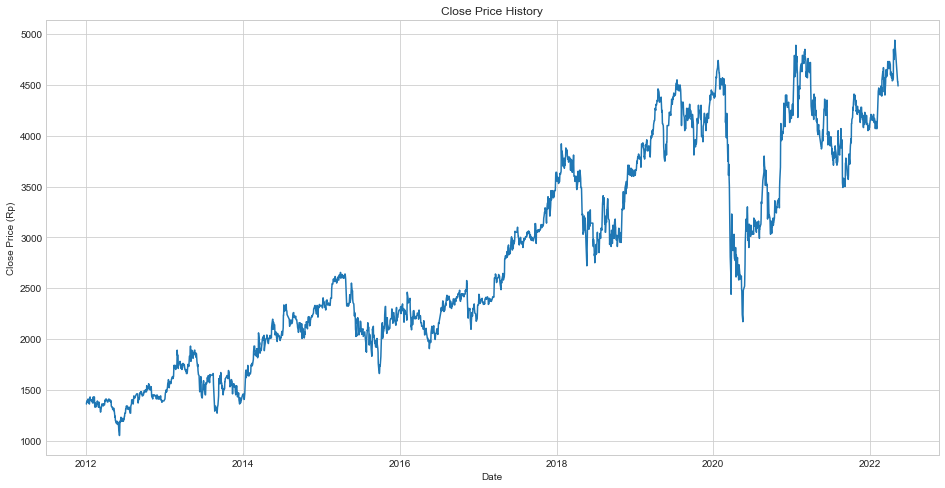

In [33]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (Rp)')
plt.show()

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2569 entries, 2012-01-02 to 2022-05-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2569 non-null   float64
 1   High       2569 non-null   float64
 2   Low        2569 non-null   float64
 3   Close      2569 non-null   float64
 4   Adj Close  2569 non-null   float64
 5   Volume     2569 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.5 KB


In [35]:
#create a new dataframe
data = df.filter(['Close'])

#convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .7)

training_data_len

1799

In [36]:
#normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [37]:
# building train data

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [38]:
# building test data

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape) 

train_data:  (1799, 1)
test_data:  (830, 1)


In [39]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
# Compiling the RNN
model.compile(loss='mean_squared_error', optimizer='Adam')

# Fitting to the training set
history = model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),batch_size=32)

Epoch 1/100
55/55 [==============================] - 12s 101ms/step - loss: 0.0187 - val_loss: 0.0046
Epoch 2/100
55/55 [==============================] - 5s 94ms/step - loss: 7.9943e-04 - val_loss: 0.0036
Epoch 3/100
55/55 [==============================] - 5s 92ms/step - loss: 7.6583e-04 - val_loss: 0.0035
Epoch 4/100
55/55 [==============================] - 5s 92ms/step - loss: 7.3474e-04 - val_loss: 0.0034
Epoch 5/100
55/55 [==============================] - 5s 93ms/step - loss: 7.3910e-04 - val_loss: 0.0031
Epoch 6/100
55/55 [==============================] - 5s 94ms/step - loss: 7.3164e-04 - val_loss: 0.0034
Epoch 7/100
55/55 [==============================] - 5s 93ms/step - loss: 8.1242e-04 - val_loss: 0.0028
Epoch 8/100
55/55 [==============================] - 5s 93ms/step - loss: 6.8222e-04 - val_loss: 0.0026
Epoch 9/100
55/55 [==============================] - 5s 95ms/step - loss: 6.2292e-04 - val_loss: 0.0024
Epoch 10/100
55/55 [==============================] - 5s 94ms/step

55/55 [==============================] - 5s 98ms/step - loss: 1.7236e-04 - val_loss: 5.3904e-04
Epoch 78/100
55/55 [==============================] - 6s 101ms/step - loss: 1.6142e-04 - val_loss: 7.5041e-04
Epoch 79/100
55/55 [==============================] - 5s 97ms/step - loss: 1.6520e-04 - val_loss: 5.7691e-04
Epoch 80/100
55/55 [==============================] - 6s 101ms/step - loss: 1.5877e-04 - val_loss: 6.2902e-04
Epoch 81/100
55/55 [==============================] - 6s 106ms/step - loss: 1.6785e-04 - val_loss: 5.4975e-04
Epoch 82/100
55/55 [==============================] - 5s 100ms/step - loss: 1.7777e-04 - val_loss: 6.4812e-04
Epoch 83/100
55/55 [==============================] - 6s 101ms/step - loss: 1.6399e-04 - val_loss: 5.5792e-04
Epoch 84/100
55/55 [==============================] - 5s 99ms/step - loss: 1.5139e-04 - val_loss: 5.7066e-04
Epoch 85/100
55/55 [==============================] - 5s 100ms/step - loss: 1.4736e-04 - val_loss: 5.4603e-04
Epoch 86/100
55/55 [======

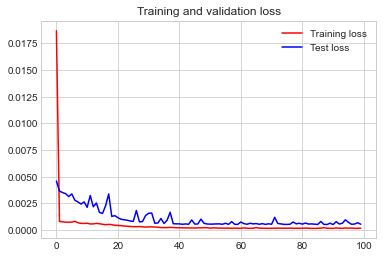

<Figure size 432x288 with 0 Axes>

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [42]:
GRU_predicted_stock_price = model.predict(x_test)
GRU_predicted_stock_price = scaler.inverse_transform(GRU_predicted_stock_price)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

train_predicted = model.predict(x_train)
train_predicted = scaler.inverse_transform(train_predicted)
ytrain = scaler.inverse_transform(y_train.reshape(-1,1))

C:\Users\mujah\AppData\Local\Temp\ipykernel_20356\2578014074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = GRU_predicted_stock_price


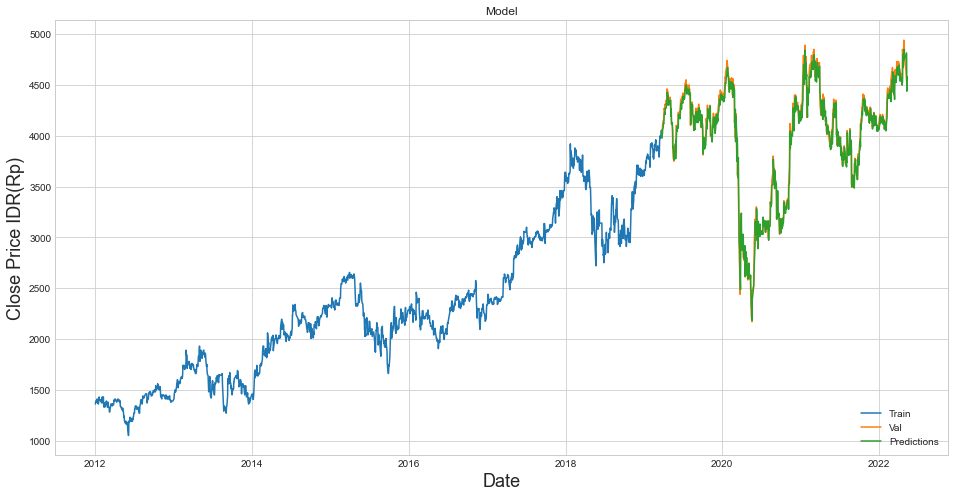

In [43]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = GRU_predicted_stock_price

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price IDR(Rp)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [44]:
print(valid.to_string())

                  Close  Predictions
Date                                
2019-03-25  4010.000000  4035.706787
2019-03-26  4060.000000  3976.115967
2019-03-27  4050.000000  4052.462158
2019-03-28  4070.000000  4018.847656
2019-03-29  4110.000000  4055.390381
2019-04-01  4150.000000  4086.471191
2019-04-02  4150.000000  4123.546875
2019-04-03  4150.000000  4118.017090
2019-04-04  4220.000000  4125.108887
2019-04-05  4270.000000  4197.301758
2019-04-08  4250.000000  4230.500488
2019-04-09  4300.000000  4209.169434
2019-04-10  4310.000000  4272.247559
2019-04-11  4300.000000  4265.928711
2019-04-12  4310.000000  4265.491699
2019-04-15  4350.000000  4278.180176
2019-04-16  4340.000000  4317.235352
2019-04-17  4340.000000  4298.536621
2019-04-18  4460.000000  4309.463379
2019-04-19  4460.000000  4427.515625
2019-04-22  4440.000000  4395.978027
2019-04-23  4430.000000  4398.717285
2019-04-24  4400.000000  4388.765625
2019-04-25  4330.000000  4363.772949
2019-04-26  4330.000000  4300.061523
2

In [45]:
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,GRU_predicted_stock_price)))
print("Test data MSE: ", mean_squared_error(y_test,GRU_predicted_stock_price))
print("Test data MAE: ", mean_absolute_error(y_test,GRU_predicted_stock_price))
print("Test data R2 score:", r2_score(y_test,GRU_predicted_stock_price))

Test data RMSE:  90.45037016475253
Test data MSE:  8181.269462940755
Test data MAE:  67.13421519886364
Test data R2 score: 0.9729952638758064


In [46]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(ytrain,train_predicted)))
print("Train data MSE: ", mean_squared_error(ytrain,train_predicted))
print("Train data MAE: ", mean_absolute_error(ytrain,train_predicted))
print("Test data R2 score:", r2_score(ytrain,train_predicted))

Train data RMSE:  45.63665788642583
Train data MSE:  2082.704543042673
Train data MAE:  31.82581836948318
Test data R2 score: 0.9959168544713974


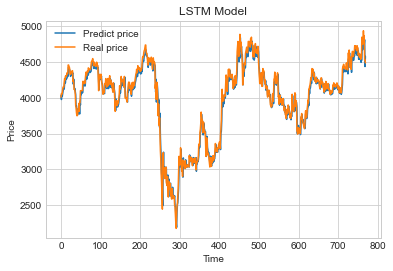

In [47]:
plt.plot(GRU_predicted_stock_price, label="Predict price")
plt.plot(y_test, label="Real price")

plt.title("LSTM Model") 
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()